In [0]:
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import itertools
import os
import keras.models as models
from keras.layers import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras import backend as K
from os.path import exists
import cv2
import numpy as np
import json
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
import glob
import numpy as np
from PIL import Image
import os, numpy, PIL
import matplotlib.pyplot as plt
from keras.optimizers import Adam
%matplotlib inline
from google.colab.patches import cv2_imshow

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!unzip '/content/drive/My Drive/submission (2).zip'

Archive:  /content/drive/My Drive/submission (2).zip
   creating: submission/
  inflating: submission/Accuracy.png  
   creating: submission/Code/
  inflating: submission/Code/0_Training.ipynb  
  inflating: submission/Code/1_test_model.py  
   creating: submission/Code/data/
   creating: submission/Code/data/test/
   creating: submission/Code/data/test/annotations/
  inflating: submission/Code/data/test/annotations/649_HC_Annotation.png  
  inflating: submission/Code/data/test/annotations/650_HC_Annotation.png  
  inflating: submission/Code/data/test/annotations/651_HC_Annotation.png  
  inflating: submission/Code/data/test/annotations/652_2HC_Annotation.png  
  inflating: submission/Code/data/test/annotations/652_HC_Annotation.png  
  inflating: submission/Code/data/test/annotations/653_HC_Annotation.png  
  inflating: submission/Code/data/test/annotations/654_HC_Annotation.png  
  inflating: submission/Code/data/test/annotations/655_HC_Annotation.png  
  inflating: submission/Code/d

In [0]:

import tensorflow as tf
import os
import random as rn
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(150)

rn.seed(150)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

tf.set_random_seed(150)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


# Define and Load Model

In [0]:
pool_size = 2
channels = 3
img_w = 224 #224
img_h = 224 #224
model_to_use = 'FCN8' 
data_shape = img_h*img_w
n_labels = 2

In [0]:
def one_hot_encode(gt_image):
    #lbl = [0,33,34,35,36,38,39,40]
    lbl = [0, 255]
    label_ohe = np.array([(np.equal(np.array(gt_image), i)) for i in lbl])

    label_ohe = np.transpose(label_ohe, (1, 2, 0))
    label_ohe = label_ohe * 1

    return label_ohe

In [0]:
train_data_files = sorted(glob.glob("/content/submission/Code/data/train/images/*.png"))
print('Train image files found ', len(train_data_files))

train_annotations_files = sorted(glob.glob("/content/submission/Code/data/train/annotations/*.png"))
print('Train annotation files found ', len(train_annotations_files))

Train image files found  800
Train annotation files found  800


In [0]:
!pip install fuzzy-c-means

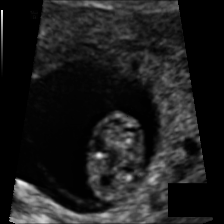

In [0]:
img = cv2.imread(train_data_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (224,224))
# img = img / 255
cv2_imshow(img)

# **K-MEANS**

In [0]:
pic_n = img.reshape(img.shape[0]*img.shape[1])
pic_n = pic_n.reshape(-1,1)
pic_n.shape

(50176, 1)

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

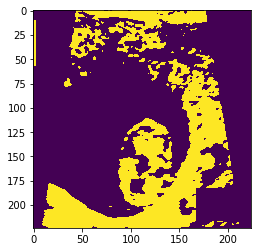

In [0]:
cluster_pic = pic2show.reshape(img.shape[0], img.shape[1])
plt.imshow(cluster_pic)

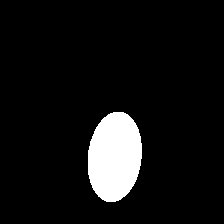

(224, 224)


(224, 224, 2)

In [0]:
image = cv2.imread(train_annotations_files[0], 0)
thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cv2.fillPoly(image, cnts, [255,255,255])

label = Image.fromarray(image).convert('P')

label=label.resize((img_w, img_h), resample=0)
label = np.array(label)


cv2_imshow(label)
print(label.shape)
one_hot_encode(label).shape
# for i in range(224):
#   for j in range(224):
#     if(label[i][j]):
#       print(i, " ", j)
#       break

In [0]:
lbl = one_hot_encode(label)
lbl[135][92]

array([1, 0])

In [0]:
def read_files(train_data_files, train_annotations):
    train_images = []
    for train_data_file in train_data_files:
#             print(train_data_file)
            img = cv2.imread(train_data_file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_w,img_h))
                        

            img = img / 255

            train_images.append(img)
        
        
    train_images = np.array(train_images) 
    
    train_labels = []
    for train_annotation in train_annotations:

        #label = Image.open(train_annotation).convert('P')
#         print(train_annotation)
        image = cv2.imread(train_annotation, 0)
        thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cv2.fillPoly(image, cnts, [255,255,255])
        
        label = Image.fromarray(image).convert('P')
        
        
        
        label=label.resize((img_w, img_h), resample=0)
        
        #print(np.unique(np.array(label)))
        label = np.array(label)
        label = one_hot_encode(label)
        train_labels.append(label)
        
    train_labels = np.array(train_labels)
    
    return(train_images, train_labels)

In [0]:

train_data_files = sorted(glob.glob("/content/submission/Code/data/train/images/*.png"))
print('Train image files found ', len(train_data_files))
train_annotations_files = sorted(glob.glob("/content/submission/Code/data/train/annotations/*.png"))
print('Train annotation files found ', len(train_annotations_files))

test_data_files = sorted(glob.glob("/content/submission/Code/data/test/images/*.png"))
print('test image files found ', len(test_data_files))
test_annotations_files = sorted(glob.glob("/content/submission/Code/data/test/annotations/*.png"))
print('test annotation files found ', len(test_annotations_files))

Train image files found  800
Train annotation files found  800
test image files found  199
test annotation files found  199


In [0]:
def batch_generator(train_data_files, train_annotations_files, batch_size):
    n = len(train_data_files)
    train_data_files = np.array(train_data_files)
    train_annotations_files = np.array(train_annotations_files)
    
    if (n==0):
        print ('Dataset not avialable')
    indexes = np.arange(len(range(0,n)))
    while True:
        batch_start = 0
        batch_end = batch_size
        np.random.shuffle(indexes)
        while batch_start < n-batch_size:
            index = indexes[batch_start:batch_end]
            x = np.array(train_data_files[index])
            y = np.array(train_annotations_files[index])
            
            train, train_labels = read_files(x, y)
            train_labels = np.reshape(train_labels,(len(train_labels),data_shape,n_labels))
           
            yield(train, train_labels)
           
            batch_start += batch_size  
            batch_end += batch_size


In [0]:
test, test_labels = read_files(test_data_files, test_annotations_files)
test_labels = np.reshape(test_labels,(len(test_labels),data_shape,n_labels))

In [0]:
#train, train_labels = read_files(train_data_files, train_annotations_files)


# FCN

In [0]:
vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor=None,input_shape=(img_h, img_w, 3))
batchsize=1
def FCN8():
    #(samples, channels, rows, cols)
    ip = Input(shape=(img_h, img_w, 3))
    h = vgg16.layers[1](ip)
    h = vgg16.layers[2](h)
    h = vgg16.layers[3](h)
    h = vgg16.layers[4](h)
    h = vgg16.layers[5](h)
    h = vgg16.layers[6](h)
    h = vgg16.layers[7](h)
    h = vgg16.layers[8](h)
    h = vgg16.layers[9](h)
    h = vgg16.layers[10](h)

    p3 = h

    h = vgg16.layers[11](h)
    h = vgg16.layers[12](h)
    h = vgg16.layers[13](h)
    h = vgg16.layers[14](h)

    p4 = h

    h = vgg16.layers[15](h)
    h = vgg16.layers[16](h)
    h = vgg16.layers[17](h)
    h = vgg16.layers[18](h)

    p5 = h

    # VGG Ended Here and FCN modifications started ....
    p3 = Convolution2D(n_labels, (1, 1), activation='relu', padding='valid')(p3)

    p4 = Convolution2D(n_labels, (1, 1), activation='relu')(p4)

    p4 = Conv2DTranspose(n_labels, (4, 4), strides=(2, 2),padding='valid')(p4)
    p4 = Cropping2D(((1, 1), (1, 1)))(p4)



    p5 = Convolution2D(n_labels, (1, 1), activation='relu')(p5)

    p5 = Conv2DTranspose(n_labels, (8, 8),strides=(4, 4),padding='valid')(p5)
    p5 = Cropping2D(((2, 2), (2, 2)))(p5)

    # merge scores
    h = Add()([ p3 , p4, p5 ])
    
    #FCN 8
    h = Conv2DTranspose(n_labels, (16, 16),strides=(8, 8),padding='valid')(h)
    h = Cropping2D(((4, 4), (4, 4)))(h)

    o_shape = Model(ip , h ).output_shape
    outputHeight = o_shape[2]
    outputWidth = o_shape[3]
    h = (Reshape((data_shape, n_labels)))(h)
    #h = (Permute((2, 1)))(h)
    h = (Activation('softmax'))(h)

    return Model(ip, h)
model = FCN8()




58892288/58889256 [==============================] - 5s 0us/step






In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[1][0]               
____________________________________________________________________________________________

### leave the optimizer to adadelta. It performs best. checked nadam, rmsprop, adadelta

In [0]:
batch_size = 5 #34 , 2
train_gen = batch_generator(train_data_files, train_annotations_files, batch_size)


train_steps = len(train_data_files)//(batch_size)

model.compile(loss="categorical_crossentropy", optimizer='adadelta', metrics=["acc"])

bst_weights_path='/content/submission/Code/models/' + model_to_use + '_weights.hdf5'
logCallback = CSVLogger('/content/submission/code/logs/' + model_to_use + '_trainingLog.csv' , separator=',', append=False)

checkpoint = ModelCheckpoint(bst_weights_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=2, min_lr=0.000000001, verbose=1)
early_stopping = EarlyStopping(monitor='val_acc', patience=20)
callbacks=[checkpoint, reduce_lr, early_stopping ]#,logCallback]


history = model.fit_generator(train_gen,train_steps, epochs=40, verbose=1,max_queue_size=8, 
                                  validation_data=(test, test_labels), shuffle =True,
                                  workers=1,use_multiprocessing= False,
                                  
                                  initial_epoch=0, callbacks=callbacks)

160/160 [==============================] - 11s 70ms/step - loss: 0.0192 - acc: 0.9918 - val_loss: 0.0687 - val_acc: 0.9807

Epoch 00023: val_acc did not improve from 0.98075
Epoch 24/40
160/160 [==============================] - 11s 70ms/step - loss: 0.0196 - acc: 0.9917 - val_loss: 0.0687 - val_acc: 0.9807

Epoch 00024: val_acc did not improve from 0.98075

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.0239998573524645e-07.
Epoch 25/40
160/160 [==============================] - 11s 70ms/step - loss: 0.0193 - acc: 0.9918 - val_loss: 0.0687 - val_acc: 0.9807

Epoch 00025: val_acc did not improve from 0.98075
Epoch 26/40
160/160 [==============================] - 11s 70ms/step - loss: 0.0195 - acc: 0.9917 - val_loss: 0.0687 - val_acc: 0.9807

Epoch 00026: val_acc did not improve from 0.98075

Epoch 00026: ReduceLROnPlateau reducing learning rate to 2.0479997431266386e-08.


In [0]:


train_data_files = sorted(glob.glob("/content/submission/Code/data/train/images/*.png"))
print('Train image files found ', len(train_data_files))
train_annotations_files = sorted(glob.glob("/content/submission/Code/data/train/annotations/*.png"))
print('Train annotation files found ', len(train_annotations_files))

test_data_files = sorted(glob.glob("/content/submission/Code/data/test/images/*.png"))
print('test image files found ', len(test_data_files))
test_annotations_files = sorted(glob.glob("/content/submission/Code/data/test/annotations/*.png"))
print('test annotation files found ', len(test_annotations_files))

Train image files found  800
Train annotation files found  800
test image files found  199
test annotation files found  199


In [0]:
import os
os.chdir('submission')

In [0]:
os.chdir('Code/models/')

In [0]:
!cd ..

In [0]:
model.save('model.h5')

# Create Segmentation Map from Predicted Classes

> Indented block



In [0]:

background = [0,0,0]
fetus = [255, 0, 0]


label_colours = np.array([background, fetus])

def plot_images(predicted_mask):
    r = predicted_mask.copy()
    g = predicted_mask.copy()
    b = predicted_mask.copy()
    for l in range(0,n_labels):
        r[predicted_mask==l]=label_colours[l,0]
        g[predicted_mask==l]=label_colours[l,1]
        b[predicted_mask==l]=label_colours[l,2]

    rgb = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3))
    rgb[:,:,0] = (r)#[:,:,0]
    rgb[:,:,1] = (g)#[:,:,1]
    rgb[:,:,2] = (b)#[:,:,2]
    return rgb

In [0]:
n_labels

2

# Custom Testing

In [0]:
train, train_labels = read_files(train_data_files, train_annotations_files)
train_labels = np.reshape(train_labels,(len(train_labels),data_shape,n_labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


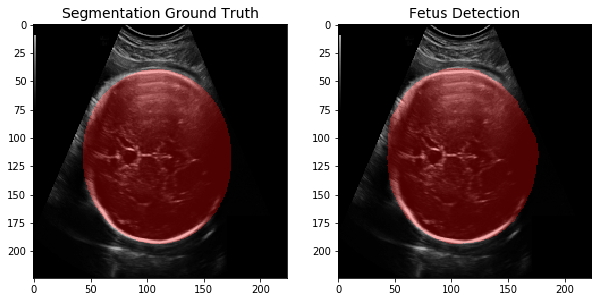

In [0]:

sample = 98

sample_image = test[sample]
sample_annot = test_labels[sample]



sample_image_p = np.expand_dims(sample_image, axis=0)
output = model.predict(sample_image_p)
pred =plot_images(np.argmax(output[0],axis=1).reshape((img_h,img_w)))


plt.figure(figsize = (10,5))  


tmp = np.argmax(sample_annot, axis=1).reshape(img_h,img_w)
true = plot_images(tmp)
plt.subplot(1,2,1)
plt.title("Segmentation Ground Truth", fontsize=14)
plt.imshow(sample_image)
plt.imshow(true,'jet', interpolation='none', alpha=0.3)

# Overlay
plt.subplot(1,2,2)
plt.title("Fetus Detection", fontsize=14)
plt.imshow(sample_image)
plt.imshow(pred, 'jet', interpolation='none', alpha=0.3)


# plt.savefig('Testing.png', format = 'png', dpi = 600)

In [0]:
output[0][1]

array([9.9993980e-01, 6.0208313e-05], dtype=float32)

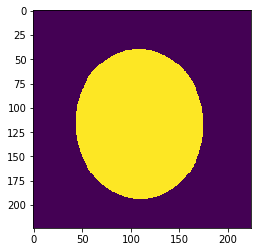

In [0]:
plt.imshow(np.argmax(sample_annot,axis=1).reshape((img_h,img_w)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


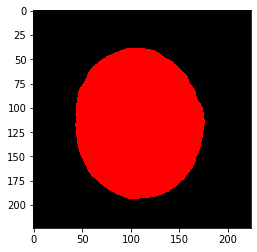

In [0]:
plt.imshow(pred)

# **Per pixel accuracy**

In [0]:
count = 0
for i in range(len(sample_annot)):
  if(np.argmax(sample_annot[i]) == np.argmax(output[0][i])):
    count+=1
print(count/len(sample_annot))  

0.9901945153061225


In [0]:
sample_annot_p = np.expand_dims(sample_annot, axis=0)
model.evaluate(test,test_labels)

199/199 [==============================] - 2s 9ms/step


[0.06867473860781396, 0.9806894785794781]

# JACCARD INDEX

In [0]:
def jaccard_index_one(sample_annot,output,cs):
  a = 0
  b = 0
  aib = 0
  for i in range(len(sample_annot)):
    if(np.argmax(sample_annot[i]) == cs):
      a+=1
    if(np.argmax(output[0][i]) == cs):
      b+=1
  for i in range(len(sample_annot)):
    if(np.argmax(sample_annot[i]) == cs and np.argmax(sample_annot[i]) == np.argmax(output[0][i])):
      aib+=1    
  aub = a+b-aib
  return aib/aub

In [0]:
jsum1 = 0
jsum0 = 0
for index in range(len(test)):
  sample_image = test[index]
  sample_annot = test_labels[index]
  sample_image_p = np.expand_dims(sample_image, axis=0)
  output = model.predict(sample_image_p)
  jsum1 += jaccard_index_one(sample_annot,output,1)
  jsum0 += jaccard_index_one(sample_annot,output,0)


In [0]:
print("Jaccard index for class1(Segmented part):", jsum1/len(test))
print("Jaccard index for class0:", jsum0/len(test))

Jaccard index for class1(Segmented part): 0.9417481172296913
Jaccard index for class0: 0.9711559974847294


In [0]:
!git clone https://github.com/jqmviegas/jqm_cvi

In [0]:
%cd jqm_cvi
!python setup.py install

In [0]:
df = sample_image.ravel()
y_pred = pred.ravel()

In [0]:
set(df)

In [0]:

import pandas as pd 
from sklearn import datasets 
from jqmcvi import base 
  
  
# We store the K-means results in a dataframe 
df = pd.DataFrame(df)
pred = pd.DataFrame(y_pred) 
pred.columns = ['Type'] 
  
# we merge this dataframe with df 
prediction = pd.concat([df, pred], axis = 1) 
  
# We store the clusters 
clus0 = prediction.loc[prediction.Type == 0.0] 
clus1 = prediction.loc[prediction.Type == 255.0] 
cluster_list = [clus0.values, clus1.values] 
  
# print(base.dunn(cluster_list))

In [0]:
print(base.dunn(cluster_list))

# END